In [44]:
# Load data set and target values
import sys
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/Preprocess')
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/DAlgorithms')

import Preprocessdata
import RFclass

from __future__ import print_function
from __future__ import division

import logging
from sklearn.datasets import make_classification
from sklearn.cross_validation import cross_val_score

from sklearn.ensemble import RandomForestClassifier as RFC


from bayes_opt import BayesianOptimization
from pandas.core.frame import DataFrame
import numpy as np
import pandas as pd


p= Preprocessdata.standardprocess()


save_path = '/home/peng/Documents/Project_C/Turbofan/Dataset/'
#names = xrange(0,28)

dfoo = pd.read_csv(save_path + 'train_FD001_80_20_com.txt', header=0)

#df = pd.read_csv(save_path + 'train_FD001_2_disc.txt', header=0)
#dfo = dfoo.sample(20000)
rad_stat = 2
seed = 'rf'

#print (dfoo)



In [52]:

# preprocess the data drop the first column
df_drop0 = dfoo.drop(dfoo.columns[[0]], axis=1)
df_dropratio =  df_drop0.drop('ratio', axis=1)
df_droptarget =  df_dropratio.drop('target_easy', axis=1)
#print (df_droptarget)

df_droptarget -= df_droptarget.min()
df_droptarget /=df.max()
#### scale the training dataset first and then apply the rules to test set 
#train, trainlabel, test, testlabel = p.sep_scale_divd(df, 0.7)
#print (test[0:10])

In [75]:
'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
train = np.array(df_droptarget)
test = np.array(df_droptarget)[10000:]

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
import timeit


start = timeit.default_timer()

batch_size = 100
original_dim = 24
latent_dim = 2
intermediate_dim = 12
nb_epoch = 500

#x= Input(shape=(24,))
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

vae.fit(train, train,
        #shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        verbose = 0)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(train
                                , batch_size=batch_size
                                )

stop = timeit.default_timer()

print ("The running takes %r min" %((stop-start)/60))

The running takes 1.1707782983779906 min


In [76]:
df_label = pd.DataFrame({'mean': x_test_encoded[:,0], 'std': x_test_encoded[:, 1], 'label': dfoo['target_easy'],
                        'ratio': dfoo['ratio']})

#print (df_label)

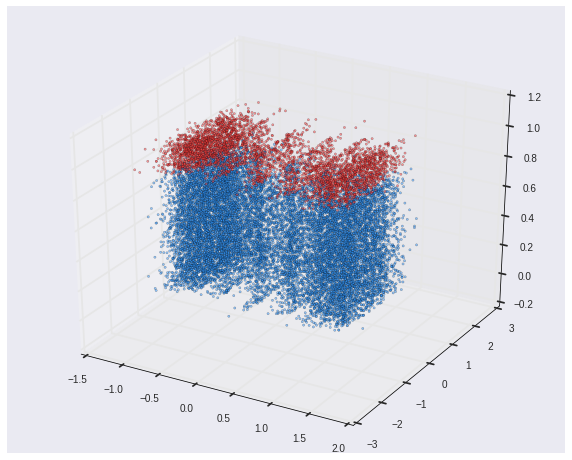

In [77]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_label[df_label['label']==0]['mean'], df_label[df_label['label']==0]['std'], 
            df_label[df_label['label']==0]['ratio'],
            c= '#3399ff', alpha=0.5, 
            label = 'Healthy State',s = 5)

ax.scatter(df_label[df_label['label']==1]['mean'], df_label[df_label['label']==1]['std'],
            df_label[df_label['label']==1]['ratio'],
           c= '#ff4040', alpha=0.5, label = 'Degraded State', s = 5)

plt.show()

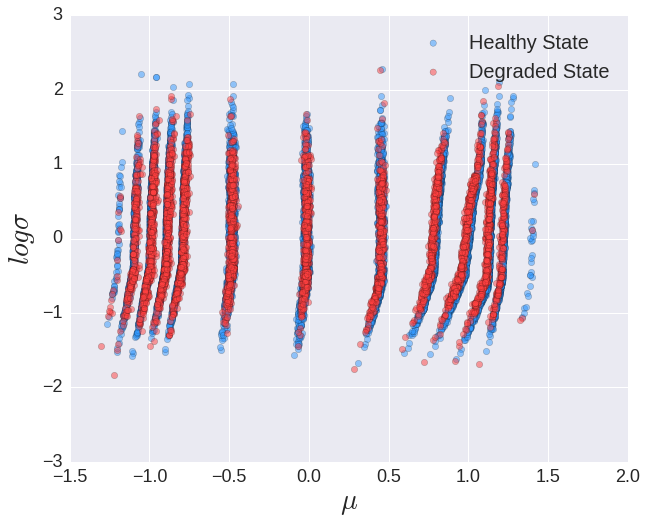

In [78]:
import seaborn as sns

plt.figure(figsize=(10, 8))

plt.scatter(df_label[df_label['label']==0]['mean'], df_label[df_label['label']==0]['std'], c= '#3399ff', alpha=0.5, 
            label = 'Healthy State',s = 40)
#plt.scatter(df_label[df_label['label']==1]['mean'], df_label[df_label['label']==1]['std'], c= 'y', alpha=0.5)

plt.scatter(df_label[df_label['label']==1]['mean'], df_label[df_label['label']==1]['std'],
            c= '#ff4040', alpha=0.5, label = 'Degraded State', s = 40)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('$\mu$',fontsize = 28)
plt.ylabel('$log\sigma$',fontsize = 28)

plt.legend(fontsize = 20)
plt.show()

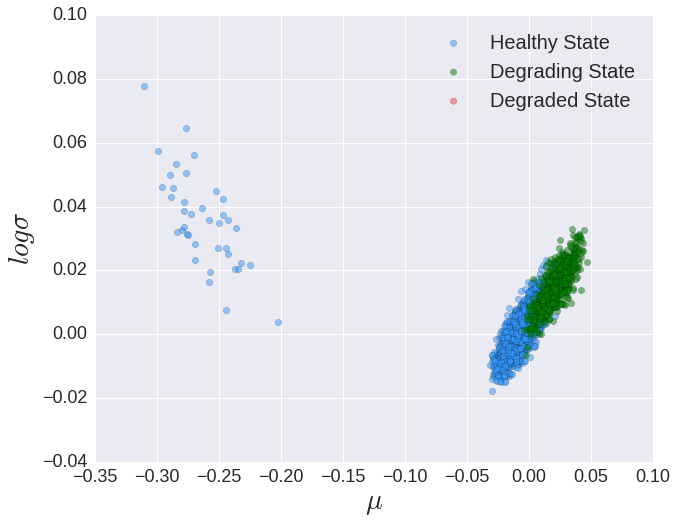

In [6]:
import seaborn as sns

plt.figure(figsize=(10, 8))

plt.scatter(df_label[df_label['label']==0]['mean'], df_label[df_label['label']==0]['std'], c= '#3399ff', alpha=0.5, 
            label = 'Healthy State',s = 40)
plt.scatter(df_label[df_label['label']==1]['mean'], df_label[df_label['label']==1]['std'], c= '#008000', alpha=0.5,
            label = 'Degrading State',s = 40)
plt.scatter(df_label[df_label['label']==2]['mean'], df_label[df_label['label']==2]['std'],c= '#ff4040', alpha=0.5,
           label = 'Degraded State',s = 40)

plt.xlabel('$\mu$',fontsize = 28)
plt.ylabel('$log\sigma$',fontsize = 28)

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

In [ ]:
df_label_11 = pd.DataFrame({'mean': x_test_encoded[:,0], 'std': x_test_encoded[:, 1], 'label': testlabel})

df_label_2 = df_label_11[df_label_11['label']!=1]

df_label_22 = df_label_2.drop(df_label_2.columns[[0]], axis=1)

print (df_label_22)


In [ ]:
output_label = np.array(df_label_2['label'])

output_label_1 = ((output_label /2)-1)*(-1)
print (output_label_1[0:10])

In [ ]:
df_label_1 = pd.DataFrame({'mean': x_test_encoded[:,0], 'std': x_test_encoded[:, 1]})


train_kmm = np.array(df_label_22)

print (train_kmm)


In [ ]:
from sklearn.cluster import KMeans

n_num = 2

k_means = KMeans(init='k-means++', n_clusters=n_num, n_init=10)
X = train_kmm
k_means.fit(train_kmm)

k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)



In [ ]:
print (np.shape(train_kmm))
print (k_means_labels[0:10])
print (df_label_2['label'][0:10])

from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report

print (confusion_matrix(k_means_labels,output_label_1))
print( classification_report(k_means_labels, output_label_1))

In [ ]:
fig = plt.figure(figsize=(8, 6))
n_clusters = 3
colors = ['#4EACC5', '#FF9C34','#4E9A06']

# KMeans

for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)




plt.show()

In [ ]:



plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c= color_list, alpha=0.5)

plt.show()